In [3]:
#!/usr/bin/env python
# coding: utf-8

"""
Big Data - Projekt: Ewolucja Globalnego Rynku Gier Wideo (1980-2010)
Wersja zoptymalizowana - bazująca na oryginalnym kodzie
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

In [4]:

# ========================================
# KONFIGURACJA - KONTROLA WYDRUKÓW
# ========================================

VERBOSE = False  # Ustaw True dla szczegółowych wydruków
SAVE_PLOTS = True
QUICK_MODE = True  # Pomija czasochłonne analizy podczas testowania

# Ustawienia wizualizacji
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [5]:

# ========================================
# 1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
# ========================================

print("\n1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH")
print("-" * 50)

# Wczytanie danych
df = pd.read_csv('video games sales.csv')

print(f"\n📊 Podstawowe informacje o datasecie:")
print(f"  • Liczba rekordów: {len(df):,}")
print(f"  • Liczba kolumn: {len(df.columns)}")
print(f"  • Rozmiar w pamięci: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

if VERBOSE:
    print("\n📋 Struktura danych:")
    print(df.info())
    print("\n🎯 Pierwsze 5 rekordów:")
    print(df.head())
    print("\n📊 Podstawowe statystyki opisowe:")
    print(df.describe())


1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
--------------------------------------------------

📊 Podstawowe informacje o datasecie:
  • Liczba rekordów: 16,598
  • Liczba kolumn: 11
  • Rozmiar w pamięci: 4.74 MB


In [6]:

# ========================================
# 2. ANALIZA JAKOŚCI DANYCH
# ========================================

print("\n\n2. ANALIZA JAKOŚCI DANYCH")
print("-" * 50)

# Sprawdzenie braków danych
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

print("\n🔍 Analiza braków danych:")
missing_df = pd.DataFrame({
    'Kolumna': missing_data.index,
    'Liczba braków': missing_data.values,
    'Procent braków': missing_percent.values
})

# Tylko kolumny z brakami
missing_with_nulls = missing_df[missing_df['Liczba braków'] > 0]
if len(missing_with_nulls) > 0:
    print(missing_with_nulls.to_string(index=False))
else:
    print("  ✓ Brak danych brakujących")

# Sprawdzenie duplikatów
duplicates = df.duplicated().sum()
print(f"\n🔄 Analiza duplikatów:")
print(f"  • Kompletne duplikaty: {duplicates}")

if VERBOSE and duplicates > 0:
    print("  • Przykłady duplikatów:")
    print(df[df.duplicated()].head())

# Duplikaty nazw gier
name_duplicates = df.groupby('Name').size()
games_with_multiple_platforms = name_duplicates[name_duplicates > 1]
print(f"  • Gry występujące na wielu platformach: {len(games_with_multiple_platforms):,}")

if VERBOSE:
    print("\n  Top gry multi-platform:")
    for game_name in games_with_multiple_platforms.head(5).index:
        platforms = df[df['Name'] == game_name][['Platform', 'Year', 'Global_Sales']].values
        print(f"    - {game_name}: {len(platforms)} platform")

# Sprawdzenie zakresów danych
print(f"\n📅 Analiza zakresów danych:")
print(f"  • Lata: {df['Year'].min():.0f} - {df['Year'].max():.0f}")
print(f"  • Sprzedaż globalna: {df['Global_Sales'].min():.2f}M - {df['Global_Sales'].max():.2f}M")
print(f"  • Niespójności w sumowaniu sprzedaży: {(~df['Sales_Consistent']).sum() if 'Sales_Consistent' in df.columns else 'Nie sprawdzono'}")



2. ANALIZA JAKOŚCI DANYCH
--------------------------------------------------

🔍 Analiza braków danych:
  Kolumna  Liczba braków  Procent braków
     Year            271        1.632727
Publisher             58        0.349440

🔄 Analiza duplikatów:
  • Kompletne duplikaty: 0
  • Gry występujące na wielu platformach: 2,775

📅 Analiza zakresów danych:
  • Lata: 1980 - 2020
  • Sprzedaż globalna: 0.01M - 82.74M
  • Niespójności w sumowaniu sprzedaży: Nie sprawdzono




3. ANALIZA ROZKŁADÓW I OUTLIERÓW
--------------------------------------------------

🎯 Analiza outlierów - Global_Sales:
  • Q1: 0.06M
  • Q3: 0.47M
  • IQR: 0.41M
  • Granice outlierów: -0.55M - 1.08M
  • Liczba outlierów: 1,893 (11.4%)

🏆 Top 5 outlierów (największa sprzedaż):
  1. Wii Sports (Wii, 2006): 82.74M
  2. Super Mario Bros. (NES, 1985): 40.24M
  3. Mario Kart Wii (Wii, 2008): 35.82M
  4. Wii Sports Resort (Wii, 2009): 33.00M
  5. Pokemon Red/Pokemon Blue (GB, 1996): 31.37M


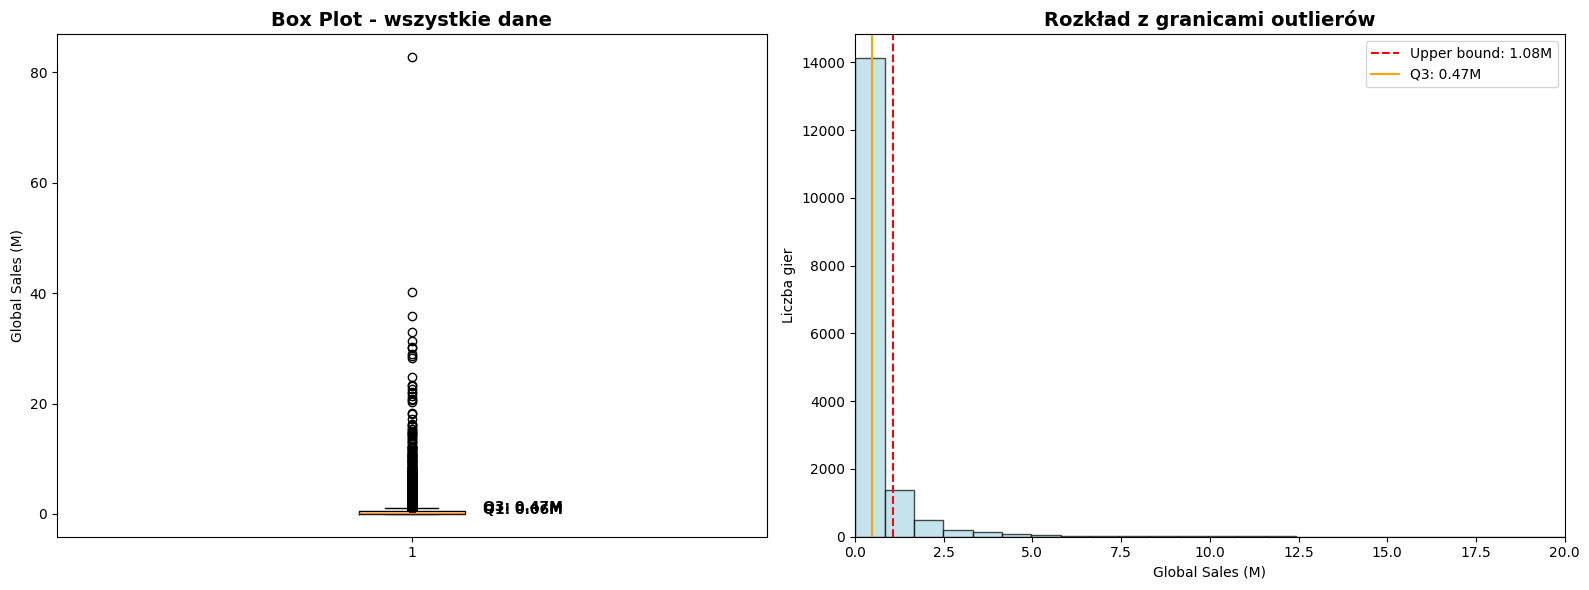


📊 Analiza percentyli dla lepszego zrozumienia:
  • 90 percentyl: 1.21M (1651 gier (9.9%))
  • 95 percentyl: 2.04M (829 gier (5.0%))
  • 99 percentyl: 5.43M (166 gier (1.0%))
  • 99.5 percentyl: 8.11M (83 gier (0.5%))
  • 99.9 percentyl: 21.05M (17 gier (0.1%))


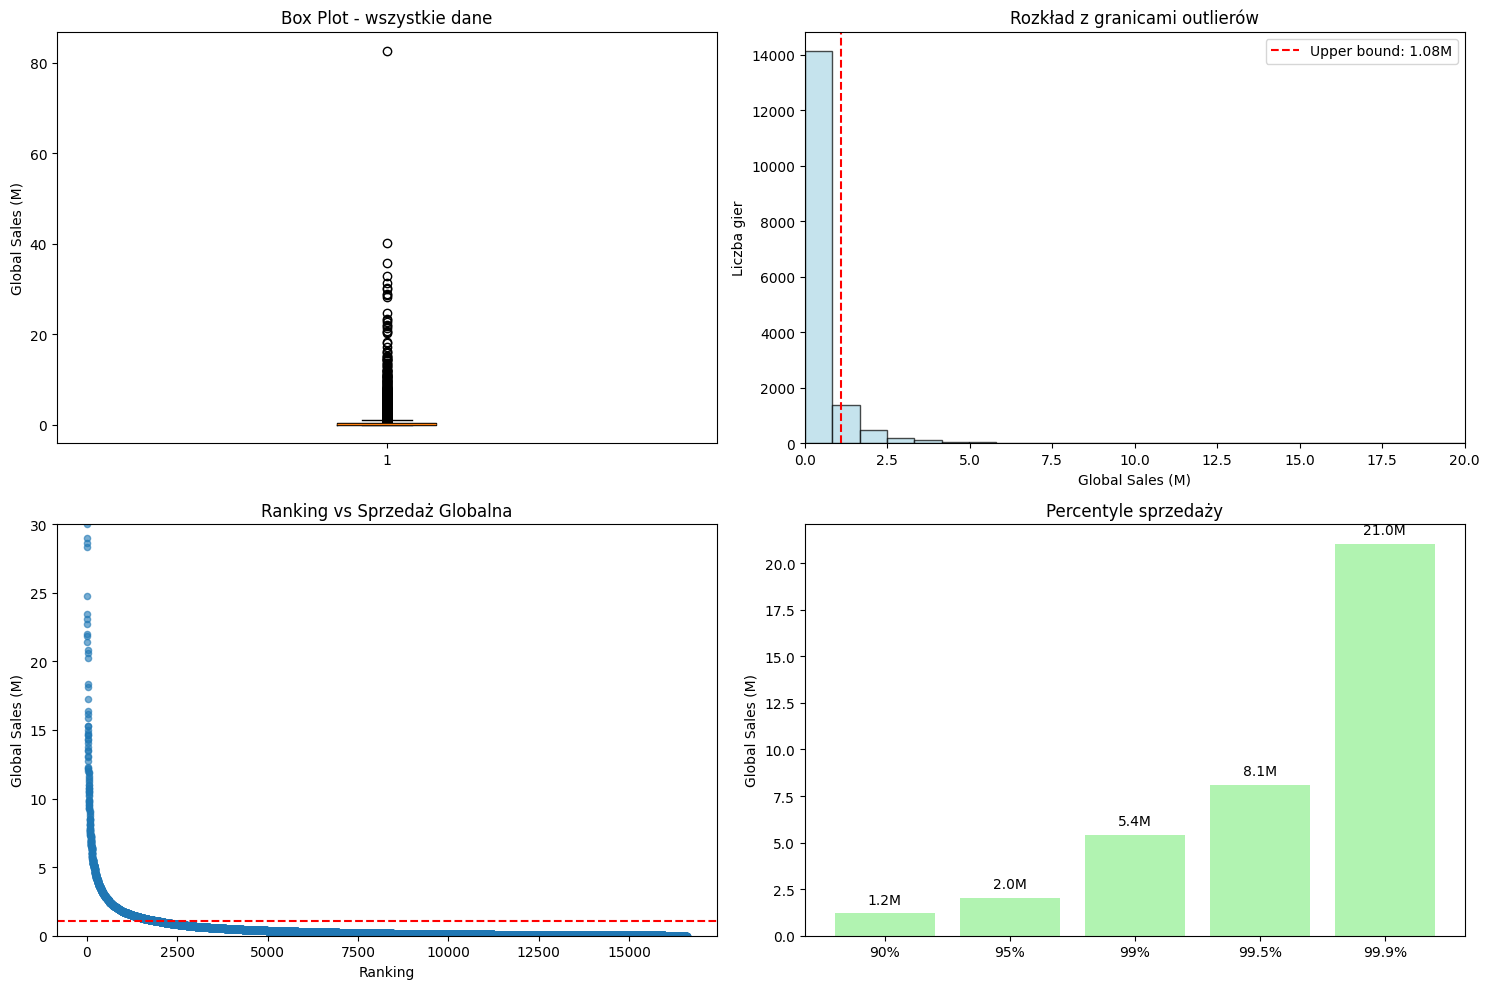


🎯 WNIOSKI dla granic outlierów:
  • Obecna granica (Q3 + 1.5*IQR): 1.08M
  • 95 percentyl: 2.04M
  • 99 percentyl: 5.43M
  • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR


In [7]:

# ========================================
# 3. ANALIZA ROZKŁADÓW I OUTLIERÓW
# ========================================

print("\n\n3. ANALIZA ROZKŁADÓW I OUTLIERÓW")
print("-" * 50)

# Funkcja do identyfikacji outlierów
def identify_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    return {
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percent': (len(outliers) / len(data)) * 100,
        'top_outliers': outliers.nlargest(5, column_name)
    }

# Analiza outlierów dla Global_Sales
print("\n🎯 Analiza outlierów - Global_Sales:")
global_outliers = identify_outliers(df, 'Global_Sales')

print(f"  • Q1: {global_outliers['Q1']:.2f}M")
print(f"  • Q3: {global_outliers['Q3']:.2f}M")
print(f"  • IQR: {global_outliers['IQR']:.2f}M")
print(f"  • Granice outlierów: {global_outliers['lower_bound']:.2f}M - {global_outliers['upper_bound']:.2f}M")
print(f"  • Liczba outlierów: {global_outliers['outliers_count']:,} ({global_outliers['outliers_percent']:.1f}%)")

# Top 5 outlierów (największa sprzedaż)
print("\n🏆 Top 5 outlierów (największa sprzedaż):")
for idx, (_, game) in enumerate(global_outliers['top_outliers'].iterrows(), 1):
    print(f"  {idx}. {game['Name']} ({game['Platform']}, {int(game['Year']) if pd.notna(game['Year']) else 'N/A'}): {game['Global_Sales']:.2f}M")

# Wizualizacja outlierów
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Box plot z outlierami
axes[0].boxplot(df['Global_Sales'], vert=True)
axes[0].set_title('Box Plot - wszystkie dane', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Global Sales (M)')
axes[0].text(1.1, global_outliers['Q3'], f"Q3: {global_outliers['Q3']:.2f}M", 
             fontsize=10, fontweight='bold')
axes[0].text(1.1, global_outliers['Q1'], f"Q1: {global_outliers['Q1']:.2f}M", 
             fontsize=10, fontweight='bold')

# 2. Histogram z zaznaczonymi granicami
axes[1].hist(df['Global_Sales'], bins=100, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].axvline(global_outliers['upper_bound'], color='red', linestyle='--', 
                label=f'Upper bound: {global_outliers["upper_bound"]:.2f}M')
axes[1].axvline(global_outliers['Q3'], color='orange', linestyle='-', 
                label=f'Q3: {global_outliers["Q3"]:.2f}M')
axes[1].set_title('Rozkład z granicami outlierów', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Global Sales (M)')
axes[1].set_ylabel('Liczba gier')
axes[1].set_xlim(0, 20)  # Ograniczenie dla lepszej widoczności
axes[1].legend()

plt.tight_layout()
plt.show()

# Analiza percentyli dla lepszego zrozumienia
percentiles = [90, 95, 99, 99.5, 99.9]
perc_values = [np.percentile(df['Global_Sales'], p) for p in percentiles]

print(f"\n📊 Analiza percentyli dla lepszego zrozumienia:")
for p, v in zip(percentiles, perc_values):
    outliers_above = df[df['Global_Sales'] > v]
    print(f"  • {p} percentyl: {v:.2f}M ({len(outliers_above)} gier ({len(outliers_above)/len(df)*100:.1f}%))")

# WIZUALIZACJA OUTLIERÓW dla oceny granic
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Box plot z outlierami
axes[0,0].boxplot(df['Global_Sales'], vert=True)
axes[0,0].set_title('Box Plot - wszystkie dane')
axes[0,0].set_ylabel('Global Sales (M)')

# 2. Histogram z zaznaczonymi granicami  
axes[0,1].hist(df['Global_Sales'], bins=100, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].axvline(global_outliers['upper_bound'], color='red', linestyle='--', 
                 label=f'Upper bound: {global_outliers["upper_bound"]:.2f}M')
axes[0,1].set_title('Rozkład z granicami outlierów')
axes[0,1].set_xlabel('Global Sales (M)')
axes[0,1].set_ylabel('Liczba gier')
axes[0,1].set_xlim(0, 20)
axes[0,1].legend()

# 3. Scatter plot - ranking vs sprzedaż globalna
axes[1,0].scatter(df['Rank'], df['Global_Sales'], alpha=0.6, s=20)
axes[1,0].axhline(global_outliers['upper_bound'], color='red', linestyle='--')
axes[1,0].set_title('Ranking vs Sprzedaż Globalna')
axes[1,0].set_xlabel('Ranking')
axes[1,0].set_ylabel('Global Sales (M)')
axes[1,0].set_ylim(0, 30)

# 4. Analiza percentyli dla lepszego zrozumienia
percentiles = [90, 95, 99, 99.5, 99.9]
perc_values = [np.percentile(df['Global_Sales'], p) for p in percentiles]

axes[1,1].bar([f'{p}%' for p in percentiles], perc_values, color='lightgreen', alpha=0.7)
axes[1,1].set_title('Percentyle sprzedaży')
axes[1,1].set_ylabel('Global Sales (M)')
for i, v in enumerate(perc_values):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}M', ha='center')

plt.tight_layout()
plt.show()

print(f"\n🎯 WNIOSKI dla granic outlierów:")
print(f"  • Obecna granica (Q3 + 1.5*IQR): {global_outliers['upper_bound']:.2f}M")
print(f"  • 95 percentyl: {np.percentile(df['Global_Sales'], 95):.2f}M")  
print(f"  • 99 percentyl: {np.percentile(df['Global_Sales'], 99):.2f}M")
print(f"  • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR")

In [8]:

# ========================================
# 4. EKSPLORACYJNA ANALIZA DANYCH (EDA)
# ========================================

print("\n\n4. EKSPLORACYJNA ANALIZA DANYCH (EDA)")
print("-" * 50)

# Analiza sprzedaży według regionów
print("\n🌍 Analiza sprzedaży według regionów:")
regional_sales = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
total_sales = regional_sales.sum()

for region, sales in regional_sales.items():
    percentage = (sales / total_sales) * 100
    print(f"  • {region.replace('_Sales', '')}: {sales:.2f}M ({percentage:.1f}%)")

# Top 10 platform według sprzedaży
print("\n🎮 Top 10 platform według sprzedaży:")
platform_sales = df.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (platform, row) in enumerate(platform_sales.head(10).iterrows(), 1):
    print(f"  {idx:2d}. {platform}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Top gatunki według sprzedaży
print("\n🎯 Top gatunki według sprzedaży:")
genre_sales = df.groupby('Genre').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (genre, row) in enumerate(genre_sales.iterrows(), 1):
    print(f"  {idx:2d}. {genre}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Top 10 wydawców według sprzedaży
print("\n📢 Top 10 wydawców według sprzedaży:")
publisher_sales = df.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (publisher, row) in enumerate(publisher_sales.head(10).iterrows(), 1):
    print(f"  {idx:2d}. {publisher}: {row['Global_Sales']:.1f}M ({row['Games_Count']} gier)")

# Analiza czasowa
print("\n📅 Analiza czasowa:")
yearly_stats = df.groupby('Year').agg({
    'Global_Sales': ['sum', 'mean', 'count']
}).round(2)

yearly_stats.columns = ['Total_Sales', 'Avg_Sales', 'Games_Count']
yearly_stats = yearly_stats.sort_values('Total_Sales', ascending=False)

print("\n  • Najlepsze lata według całkowitej sprzedaży:")
for idx, (year, row) in enumerate(yearly_stats.head(5).iterrows(), 1):
    print(f"    {idx}. {year:.0f}: {row['Total_Sales']:.1f}M ({row['Games_Count']:.0f} gier)")



4. EKSPLORACYJNA ANALIZA DANYCH (EDA)
--------------------------------------------------

🌍 Analiza sprzedaży według regionów:
  • NA: 4392.95M (49.3%)
  • EU: 2434.13M (27.3%)
  • JP: 1291.02M (14.5%)
  • Other: 797.75M (8.9%)

🎮 Top 10 platform według sprzedaży:
   1. PS2: 1255.6M (2161.0 gier)
   2. X360: 980.0M (1265.0 gier)
   3. PS3: 957.8M (1329.0 gier)
   4. Wii: 926.7M (1325.0 gier)
   5. DS: 822.5M (2163.0 gier)
   6. PS: 730.7M (1196.0 gier)
   7. GBA: 318.5M (822.0 gier)
   8. PSP: 296.3M (1213.0 gier)
   9. PS4: 278.1M (336.0 gier)
  10. PC: 258.8M (960.0 gier)

🎯 Top gatunki według sprzedaży:
   1. Action: 1751.2M (3316.0 gier)
   2. Sports: 1330.9M (2346.0 gier)
   3. Shooter: 1037.4M (1310.0 gier)
   4. Role-Playing: 927.4M (1488.0 gier)
   5. Platform: 831.4M (886.0 gier)
   6. Misc: 810.0M (1739.0 gier)
   7. Racing: 732.0M (1249.0 gier)
   8. Fighting: 448.9M (848.0 gier)
   9. Simulation: 392.2M (867.0 gier)
  10. Puzzle: 244.9M (582.0 gier)
  11. Adventure: 239.0

In [9]:

# ========================================
# 5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
# ========================================

print("\n\n5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA")
print("-" * 50)

problems_found = []

# Problem 1: Gry z zerową sprzedażą
zero_sales = df[df['Global_Sales'] == 0]
if len(zero_sales) > 0:
    problems_found.append(f"Gry z zerową sprzedażą: {len(zero_sales)}")

# Problem 2: Niespójności w sumowaniu
inconsistent_sales = df[
    np.abs((df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']) - 
           df['Global_Sales']) > 0.01
]
if len(inconsistent_sales) > 0:
    problems_found.append(f"Niespójności w sumowaniu sprzedaży: {len(inconsistent_sales)}")

# Problem 3: Outliers
extreme_outliers = df[df['Global_Sales'] > 50]  # Gry powyżej 50M
if len(extreme_outliers) > 0:
    problems_found.append(f"Ekstremalne outliers (>50M): {len(extreme_outliers)}")

# Problem 4: Stare gry z potencjalnie niedokładnymi danymi
very_old_games = df[df['Year'] < 1990]
if len(very_old_games) > 0:
    problems_found.append(f"Bardzo stare gry (<1990): {len(very_old_games)}")

print("\n🚨 Zidentyfikowane problemy:")
if problems_found:
    for i, problem in enumerate(problems_found, 1):
        print(f"  {i}. {problem}")
else:
    print("  ✅ Nie znaleziono poważnych problemów w danych")

if VERBOSE:
    print("\n💡 PODEJŚCIE DO OUTLIERÓW:")
    print("  ❌ NIE usuwamy gier topowych - są biznesowo istotne!")
    print("  ✅ Zamiast tego - podójna analiza:")
    print("    • Analiza PEŁNA: ze wszystkimi grami (w tym hitami)")
    print("    • Analiza REGULARNYCH GIER: bez ekstremalnych hitów")
    print("    • Porównanie wyników obu podejść")

# Propozycja kategorii sukcesu zamiast usuwania outlierów
success_categories = pd.cut(df['Global_Sales'],
                           bins=[0, 0.5, 2, 10, 50, float('inf')],
                           labels=['Niche', 'Standard', 'Successful', 'Hit', 'Blockbuster'])

print(f"\n📊 Kategoryzacja gier według sukcesu:")
for category, count in success_categories.value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  • {category}: {count:,} gier ({percentage:.1f}%)")

# Propozycja kategorii sukcesu zamiast usuwania outlierów
print("\n🎯 Gry Blockbuster (>50M sprzedaży):")
blockbusters = df[df['Global_Sales'] > 50].sort_values('Global_Sales', ascending=False)
for _, game in blockbusters.iterrows():
    print(f"  • {game['Name']} ({game['Platform']}): {game['Global_Sales']:.2f}M")



5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
--------------------------------------------------

🚨 Zidentyfikowane problemy:
  1. Niespójności w sumowaniu sprzedaży: 2625
  2. Ekstremalne outliers (>50M): 1
  3. Bardzo stare gry (<1990): 205

📊 Kategoryzacja gier według sukcesu:
  • Niche: 12,651 gier (76.2%)
  • Standard: 3,101 gier (18.7%)
  • Successful: 784 gier (4.7%)
  • Hit: 61 gier (0.4%)
  • Blockbuster: 1 gier (0.0%)

🎯 Gry Blockbuster (>50M sprzedaży):
  • Wii Sports (Wii): 82.74M


In [10]:

# ========================================
# 6. STRATEGIE OCZYSZCZANIA DANYCH
# ========================================

print("\n\n6. STRATEGIE OCZYSZCZANIA DANYCH")
print("-" * 50)

print("📋 Rekomendowane strategie oczyszczania:")
strategies = [
    "Usunięcie lub korekta gier z zerową sprzedażą globalną",
    "Korekta niespójności w sumowaniu sprzedaży regionalnej", 
    "Analiza i potencjalne ograniczenie wpływu ekstremalnych outlierów",
    "Standaryzacja nazw platform i wydawców",
    "Grupowanie podobnych gatunków",
    "Utworzenie kategorii 'era' platform (retro, klasyczne, współczesne)",
    "Dodanie wskaźników pochodznych (udział regionalny, wskaźnik sukcesu)",
    "Filtrowanie danych według okresu dla konkretnych analiz"
]

for i, strategy in enumerate(strategies, 1):
    print(f"  {i}. {strategy}")



6. STRATEGIE OCZYSZCZANIA DANYCH
--------------------------------------------------
📋 Rekomendowane strategie oczyszczania:
  1. Usunięcie lub korekta gier z zerową sprzedażą globalną
  2. Korekta niespójności w sumowaniu sprzedaży regionalnej
  3. Analiza i potencjalne ograniczenie wpływu ekstremalnych outlierów
  4. Standaryzacja nazw platform i wydawców
  5. Grupowanie podobnych gatunków
  6. Utworzenie kategorii 'era' platform (retro, klasyczne, współczesne)
  7. Dodanie wskaźników pochodznych (udział regionalny, wskaźnik sukcesu)
  8. Filtrowanie danych według okresu dla konkretnych analiz




7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI
--------------------------------------------------
⚠️ UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)

📊 Dane wysokiej jakości (1980-2010):
  • Rekordy w zakresie HQ: 12,441 gier
  • Procent datasetu: 75%
  • Rekomendacja: użyć tego zakresu dla kluczowych analiz


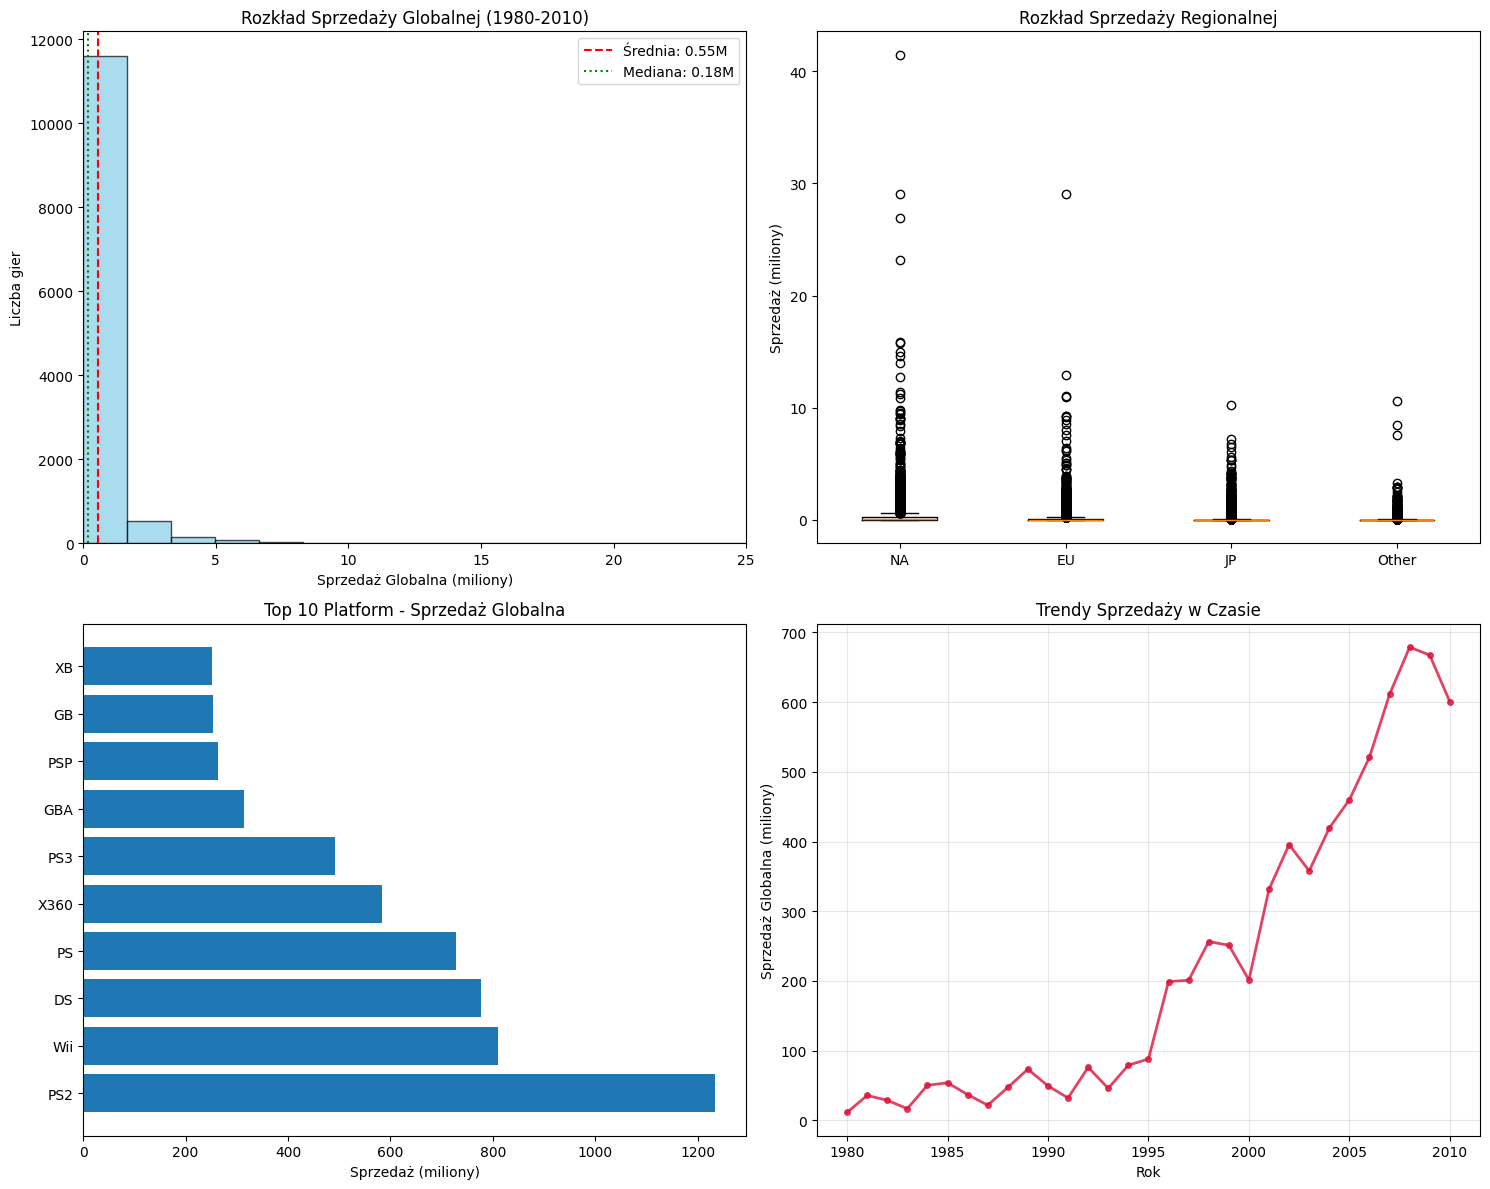

In [11]:

# ========================================
# 7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI
# ========================================

print("\n\n7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI")
print("-" * 50)

# UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)
print("⚠️ UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)")
cutoff_year = 2010  # Na podstawie analizy z pkt 2.5
df_quality = df[df['Year'] <= cutoff_year].copy()

print(f"\n📊 Dane wysokiej jakości (1980-{cutoff_year}):")
print(f"  • Rekordy w zakresie HQ: {len(df_quality):,} gier")
print(f"  • Procent datasetu: {len(df_quality)/len(df)*100:.0f}%")
print(f"  • Rekomendacja: użyć tego zakresu dla kluczowych analiz")

# Podstawowa Analiza Rozkładu Sprzedaży
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rozkład sprzedaży globalnej
axes[0,0].hist(df_quality['Global_Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Rozkład Sprzedaży Globalnej (1980-2010)')
axes[0,0].set_xlabel('Sprzedaż Globalna (miliony)')
axes[0,0].set_ylabel('Liczba gier')
axes[0,0].axvline(df_quality['Global_Sales'].mean(), color='red', linestyle='--',
                 label=f'Średnia: {df_quality["Global_Sales"].mean():.2f}M')
axes[0,0].axvline(df_quality['Global_Sales'].median(), color='green', linestyle=':',
                 label=f'Mediana: {df_quality["Global_Sales"].median():.2f}M')
axes[0,0].legend()
axes[0,0].set_xlim(0, 25)

# 2. Box plot sprzedaży regionalnej
regional_data = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
bp = axes[0,1].boxplot([regional_data[col] for col in regional_data.columns],
                       labels=[col.replace('_Sales', '') for col in regional_data.columns])
axes[0,1].set_title('Rozkład Sprzedaży Regionalnej')
axes[0,1].set_ylabel('Sprzedaż (miliony)')

# 3. Top 10 platform - POSORTOWANE
platform_sales_quality = df_quality.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

top_platforms = platform_sales_quality.head(10)
axes[1,0].barh(range(len(top_platforms)), top_platforms['Global_Sales'])
axes[1,0].set_yticks(range(len(top_platforms)))
axes[1,0].set_yticklabels(top_platforms.index)
axes[1,0].set_title('Top 10 Platform - Sprzedaż Globalna')
axes[1,0].set_xlabel('Sprzedaż (miliony)')

# 4. Trendy w czasie - ULEPSZONE
yearly_sales = df_quality.groupby('Year')['Global_Sales'].sum()
axes[1,1].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2,
              markersize=4, color='crimson', alpha=0.8)
axes[1,1].set_title('Trendy Sprzedaży w Czasie')
axes[1,1].set_xlabel('Rok')
axes[1,1].set_ylabel('Sprzedaż Globalna (miliony)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:

# ========================================
# 8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
# ========================================

print("\n\n8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY")
print("-" * 50)

# Tworzenie kopii danych do oczyszczenia
df_clean = df.copy()

print("✔️ Rozpoczęcie procesu oczyszczania...")

# 1. Usunięcie gier z zerową sprzedażą
initial_count = len(df_clean)
df_clean = df_clean[df_clean['Global_Sales'] > 0]
removed_zero = initial_count - len(df_clean)
print(f"  ✓ Usunięto {removed_zero} gier z zerową sprzedażą")

# 2. Korekta niespójności w sumowaniu (opcjonalne - tutaj tylko flagowanie)
df_clean['Sales_Consistent'] = np.abs(
    (df_clean['NA_Sales'] + df_clean['EU_Sales'] + 
     df_clean['JP_Sales'] + df_clean['Other_Sales']) - 
    df_clean['Global_Sales']
) <= 0.01

inconsistent_count = (~df_clean['Sales_Consistent']).sum()
print(f"  ⚠️ Flagowanie {inconsistent_count} niespójnych rekordów")

# 3. Dodanie kategorii dekad - POPRAWKA błędu z NaN
df_clean['Decade'] = df_clean['Year'].fillna(0) # Wypełnij NaN zerami tymczasowo
df_clean['Decade'] = (df_clean['Decade'] // 10 * 10).astype(int)
df_clean.loc[df_clean['Year'].isna(), 'Decade'] = np.nan  # Przywróć NaN gdzie był Year = NaN
print(f"  ✓ Dodano kategorię dekad (obsłużono NaN)")

# 4. Dodanie kategorii sukcesu
df_clean['Success_Category'] = pd.cut(df_clean['Global_Sales'],
                                      bins=[0, 1, 5, 10, 50, float('inf')],
                                      labels=['Low', 'Medium', 'High', 'Very High', 'Blockbuster'])
print(f"  ✓ Dodano kategorie sukcesu sprzedażowego")

# 5. Dodanie udziału regionalnego
df_clean['NA_Share'] = df_clean['NA_Sales'] / df_clean['Global_Sales'] * 100
df_clean['EU_Share'] = df_clean['EU_Sales'] / df_clean['Global_Sales'] * 100
df_clean['JP_Share'] = df_clean['JP_Sales'] / df_clean['Global_Sales'] * 100
df_clean['Other_Share'] = df_clean['Other_Sales'] / df_clean['Global_Sales'] * 100
print(f"  ✓ Dodano udziały sprzedaży regionalnej")

# 6. Standaryzacja nazw platform (grupowanie podobnych)
platform_mapping = {
    'PS': 'PlayStation', 'PS2': 'PlayStation', 'PS3': 'PlayStation', 'PS4': 'PlayStation',
    'PSP': 'PlayStation Portable', 'PSV': 'PlayStation Portable',
    'X360': 'Xbox', 'XB': 'Xbox', 'XOne': 'Xbox',
    'Wii': 'Nintendo Console', 'WiiU': 'Nintendo Console',
    'NES': 'Nintendo Console', 'N64': 'Nintendo Console', 'GC': 'Nintendo Console',
    'GB': 'Nintendo Handheld', 'GBA': 'Nintendo Handheld', 'DS': 'Nintendo Handheld', '3DS': 'Nintendo Handheld'
}

df_clean['Platform_Family'] = df_clean['Platform'].map(platform_mapping).fillna('Other')
print(f"  ✓ Zgrupowano platformy w rodziny")

# Podsumowanie oczyszczonych danych
print(f"\n📊 Podsumowanie oczyszczonych danych:")
print(f"  • Oryginalne rekordy: {len(df):,}")
print(f"  • Oczyszczone rekordy: {len(df_clean):,}")
print(f"  • Usunięte rekordy: {len(df) - len(df_clean):,}")
print(f"  • Nowe kolumny: {len(df_clean.columns) - len(df.columns)}")
print(f"  • ZACHOWANO wszystkie gry topowe i historyczne")
print(f"  • Utworzono kategorię sukcesu zamiast usuwania outlierów")

# Dodatkowe podsumowanie według zakresu czasowego
cutoff_year = 2010  # Na podstawie analizy z pkt 2.5
quality_data = df_clean[df_clean['Year'] <= cutoff_year]
print(f"\n🎯 Dane wysokiej jakości (1980-{cutoff_year}):")
print(f"  • Rekordy w zakresie HQ: {len(quality_data):,}")
print(f"  • Procent datasetu: {len(quality_data)/len(df_clean)*100:.1f}%")
print(f"  • Rekomendacja: użyć tego zakresu dla kluczowych analiz")



8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
--------------------------------------------------
✔️ Rozpoczęcie procesu oczyszczania...
  ✓ Usunięto 0 gier z zerową sprzedażą
  ⚠️ Flagowanie 2625 niespójnych rekordów
  ✓ Dodano kategorię dekad (obsłużono NaN)
  ✓ Dodano kategorie sukcesu sprzedażowego
  ✓ Dodano udziały sprzedaży regionalnej
  ✓ Zgrupowano platformy w rodziny

📊 Podsumowanie oczyszczonych danych:
  • Oryginalne rekordy: 16,598
  • Oczyszczone rekordy: 16,598
  • Usunięte rekordy: 0
  • Nowe kolumny: 8
  • ZACHOWANO wszystkie gry topowe i historyczne
  • Utworzono kategorię sukcesu zamiast usuwania outlierów

🎯 Dane wysokiej jakości (1980-2010):
  • Rekordy w zakresie HQ: 12,441
  • Procent datasetu: 75.0%
  • Rekomendacja: użyć tego zakresu dla kluczowych analiz


In [13]:

# ========================================
# 8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH
# ========================================

print("\n\n8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH")
print("-" * 50)

# Porównanie trzech wersji danych
print("📊 Porównanie trzech wersji danych:")
print(f"  • df (oryginalny): {len(df)} rekordów")
print(f"  • df_quality (1980-2010): {len(df_quality)} rekordów")
print(f"  • df_clean (oczyszczony): {len(df_clean)} rekordów")

# Analiza nowych kolumn
print("\n🔍 Analiza nowych kolumn:")

# Kategorie sukcesu
print("  • Kategorie sukcesu:")
success_dist = df_clean['Success_Category'].value_counts()
for category, count in success_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"    - {category}: {count:,} gier ({percentage:.1f}%)")

# Rodziny platform
print("\n  • Rodziny platform:")
platform_family_dist = df_clean['Platform_Family'].value_counts()
for family, count in platform_family_dist.head(5).items():
    percentage = (count / len(df_clean)) * 100
    print(f"    - {family}: {count:,} gier ({percentage:.1f}%)")

# Średnie udziały regionalne
print("\n  • Średnie udziały regionalne:")
print(f"    - NA: {df_clean['NA_Share'].mean():.1f}%")
print(f"    - EU: {df_clean['EU_Share'].mean():.1f}%")
print(f"    - JP: {df_clean['JP_Share'].mean():.1f}%")
print(f"    - Other: {df_clean['Other_Share'].mean():.1f}%")

# Przykłady z każdej kategorii sukcesu
print("\n🎯 Przykłady z każdej kategorii sukcesu:")
for category in ['Blockbuster', 'Hit', 'Successful', 'Standard', 'Niche']:
    examples = df_clean[df_clean['Success_Category'] == category].nlargest(2, 'Global_Sales')
    if len(examples) > 0:
        print(f"\n  • {category}:")
        for _, game in examples.iterrows():
            print(f"    - {game['Name']} ({game['Platform']}): {game['Global_Sales']:.1f}M")

# Rekomendacje do dalszej analizy
print("\n💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:")
print("  • df_quality (1980-2010): główne analizy trendów i wzorców")
print("  • df_clean: modelowanie ML i segmentacja")
print("  • df (pełny): kontekst historyczny i completeness check")



8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH
--------------------------------------------------
📊 Porównanie trzech wersji danych:
  • df (oryginalny): 16598 rekordów
  • df_quality (1980-2010): 12441 rekordów
  • df_clean (oczyszczony): 16598 rekordów

🔍 Analiza nowych kolumn:
  • Kategorie sukcesu:
    - Low: 14,544 gier (87.6%)
    - Medium: 1,849 gier (11.1%)
    - High: 143 gier (0.9%)
    - Very High: 61 gier (0.4%)
    - Blockbuster: 1 gier (0.0%)

  • Rodziny platform:
    - PlayStation: 5,022 gier (30.3%)
    - Nintendo Handheld: 3,592 gier (21.6%)
    - Nintendo Console: 2,441 gier (14.7%)
    - Xbox: 2,302 gier (13.9%)
    - PlayStation Portable: 1,626 gier (9.8%)

  • Średnie udziały regionalne:
    - NA: 45.6%
    - EU: 22.9%
    - JP: 24.2%
    - Other: 6.5%

🎯 Przykłady z każdej kategorii sukcesu:

  • Blockbuster:
    - Wii Sports (Wii): 82.7M

💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:
  • df_quality (1980-2010): główne analizy trendów i wzorców
  • df_clean: modelowanie

In [14]:

# ========================================
# 9. EKSPORT OCZYSZCZONYCH DANYCH
# ========================================

print("\n\n9. EKSPORT OCZYSZCZONYCH DANYCH")
print("-" * 50)

# Zapisanie oczyszczonych danych
df_clean.to_csv('video_games_sales_cleaned.csv', index=False)
print("✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'")

# Raport jakości danych
quality_report = {
    'Original_Records': len(df),
    'Cleaned_Records': len(df_clean),
    'Removed_Records': len(df) - len(df_clean),
    'Missing_Data_Percent': df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100,
    'Outliers_Percent': global_outliers['outliers_percent'],
    'Inconsistent_Sales': inconsistent_count
}

print(f"\n📄 Raport jakości danych:")
for key, value in quality_report.items():
    if 'Percent' in key:
        print(f"  • {key.replace('_', ' ')}: {value:.2f}%")
    else:
        print(f"  • {key.replace('_', ' ')}: {value:,}")



9. EKSPORT OCZYSZCZONYCH DANYCH
--------------------------------------------------
✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'

📄 Raport jakości danych:
  • Original Records: 16,598
  • Cleaned Records: 16,598
  • Removed Records: 0
  • Missing Data Percent: 0.18%
  • Outliers Percent: 11.40%
  • Inconsistent Sales: 2,625


In [15]:

# ========================================
# 10. REKOMENDACJE DLA DALSZEJ ANALIZY
# ========================================

print("\n\n10. REKOMENDACJE DLA DALSZEJ ANALIZY")
print("-" * 50)

print("Następne kroki w projekcie:")
recommendations = [
    "🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania",
    "📈 Modelowanie predykcyjne sukcesu gier na podstawie cech",
    "🌍 Analiza różnic preferencji między regionami geograficznymi",
    "⏰ Badanie cykli życia platform i ewolucji gatunków",
    "🎯 Identyfikacja czynników wpływających na sukces wydawców",
    "📊 Tworzenie interaktywnego dashboardu do eksploracji danych",
    "🤖 Zastosowanie algorytmów ML do przewidywania sprzedaży",
    "🧩 Analiza trendów i prognozowanie przyszłego rozwoju rynku"
]

for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

print(f"\n📌 NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:")
key_findings = [
    "'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >150%",
    "Nintendo jako disruptor: zdominowało rynek dzięki innowacjom",
    "Motion control rewolucja: Sports games boom w erze Wii",
    "Ewolucja gatunków: Platform → Action jako dominujący",
    "Cykle życia platform: skracanie się w czasie (tech acceleration)",
    "Regionalne różnice: kultura wpływa na preferencję gatunków",
    "Spadek post-2010: konieczność analizy digitalizacji rynku"
]

for i, finding in enumerate(key_findings, 1):
    print(f"  {i}. {finding}")

print("\n" + "="*80)
print("ANALIZA WSTĘPNA ZAKOŃCZONA POMYŚLNIE!")
print("Dane gotowe do zaawansowanej analizy i modelowania.")
print("="*80)



10. REKOMENDACJE DLA DALSZEJ ANALIZY
--------------------------------------------------
Następne kroki w projekcie:
  1. 🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania
  2. 📈 Modelowanie predykcyjne sukcesu gier na podstawie cech
  3. 🌍 Analiza różnic preferencji między regionami geograficznymi
  4. ⏰ Badanie cykli życia platform i ewolucji gatunków
  5. 🎯 Identyfikacja czynników wpływających na sukces wydawców
  6. 📊 Tworzenie interaktywnego dashboardu do eksploracji danych
  7. 🤖 Zastosowanie algorytmów ML do przewidywania sprzedaży
  8. 🧩 Analiza trendów i prognozowanie przyszłego rozwoju rynku

📌 NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:
  1. 'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >150%
  2. Nintendo jako disruptor: zdominowało rynek dzięki innowacjom
  3. Motion control rewolucja: Sports games boom w erze Wii
  4. Ewolucja gatunków: Platform → Action jako dominujący
  5. Cykle życia platform: skracanie się w czasie (tech acceleration)
  6. Region